In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

## Creating Bak-Sneppen model

Steps:
Inititalize percolation grid
Start time loop
For every time iteration:
    Calculate probabilities that neighbours change

In [30]:
class SimulationGrid:
    def __init__(self, size, low=0.0, high=1.0):
        self.size = size
        self.threshold = []
        self.low = low
        self.high = high
        self.fitness_max = -1
        self.history = []
        self.num_iterations = 0
        self.avalanche_length = []
        self.current = self.initialize_grid()
        self.lambda_rate = 0.9  # Adjust as needed
        # Schedule the first information event
        self.time_for_next_info = np.random.exponential(scale=1/self.lambda_rate)
        
    def restart(self):
        self.current = self.initialize_grid()
        self.history = []
        self.threshold_fitness = []
        self.fitness_max = -1

    def initialize_grid(self):
        return np.array([[np.random.uniform(self.low, self.high) for _ in range(self.size)] for _ in range(self.size)])

    def visualize(self):
        cmap = 'viridis'
        plt.imshow(self.current, cmap=cmap, interpolation='nearest')
        plt.title('2D Grid Initialized with Uniform Distribution')
        plt.colorbar()
        plt.show()

    def draw_value(self):
#         return np.random.normal(loc=self.mean, scale=self.std, size=(self.size, self.size))
        return np.random.uniform(self.low, self.high)

    def avalanche_frequencies(self):  
        freq = {}
        for value in self.avalanche_length:
            if value in freq:
                freq[value] += 1
            else:
                freq[value] = 1
                
        lst = np.array([[key,freq[key]] for key in freq])
        return lst
    
    def introduce_new_information(self, current_time, fitness_value):
        """
        Introduces a cluster of new information based on an exponential distribution to 
        determine the timing of events.
        
        :param current_time: The current time step in the simulation.
        :param fitness_value: The fitness value to assign to the new information clusters.
        """
        if current_time >= self.time_for_next_info:
            # Determine the number of clusters to introduce (can be based on Poisson or another approach)
            num_clusters = np.random.poisson(self.lambda_rate)

            for _ in range(num_clusters):
                # Select a random site for the new information
                site = np.random.randint(0, self.size)
                # Update self.current instead of self.grid
                i, j = np.unravel_index(site, self.current.shape)
                self.current[i, j] = fitness_value

            # Schedule the next information event
            self.time_for_next_info += np.random.exponential(scale=1/self.lambda_rate)
            
    def adjust_neighbor_fitness(self, i, j):
        """
        Adjusts the fitness of a neighbor based on its original value.
        The adjustment weight is randomly chosen from U(0,1) and the direction (+ or -)
        is determined by a Bernoulli trial.
        """
        original_value = self.current[i, j]
        weight = np.random.uniform(0, 1)  # Weight is randomly chosen from U(0,1)
        change_direction = 1 if np.random.rand() < 0.5 else -1 # Direction is determined by a Bernoulli trial
        adjustment = original_value * weight * change_direction
        new_value = original_value + adjustment

        # Ensure the new value is within the bounds -> [0,1]
        return max(min(new_value, self.high), self.low)

    def run_iterations(self, iterations, dx=None):
        self.num_iterations= iterations
        avalanche_size = 0
        for t in range(iterations):
            
            # Introduce new information if the time has come
            self.introduce_new_information(t, fitness_value=0.1)
            
            self.history.append(self.current.copy())  # Use copy to save the state, not a reference

            # Getting min index and saving minimum value
            min_index = np.unravel_index(self.current.argmin(), self.current.shape)
            minimum = self.current[min_index[0], min_index[1]]
            
            #Updating fitness threshold and saving
            avalanche_size += 1
            if  self.fitness_max < minimum:
                    self.avalanche_length.append(avalanche_size-1)
                    self.threshold.append(minimum)
                    self.fitness_max = minimum
                    avalanche_size = 0 
            

            # I could make this part more efficient but too lazy for now
            neighbors = [
                (min_index[0] - 1, min_index[1]),  # Above
                (min_index[0] + 1, min_index[1]),  # Below
                (min_index[0], min_index[1] - 1),  # Left
                (min_index[0], min_index[1] + 1)   # Right
            ]

            # Keeping only 'useful' indexes
            indices = [(i, j) for i, j in neighbors if 0 <= i < self.current.shape[0] and 0 <= j < self.current.shape[1]]

            # Updating neighbors and worst value
#             for index in indices:
#                 i, j = index
#                 self.current[i, j] = self.draw_value()

#             self.current[min_index[0], min_index[1]] = self.draw_value()
            
            for i, j in indices:
                self.current[i, j] = self.adjust_neighbor_fitness(i, j)
                
            self.current[min_index[0], min_index[1]] = self.draw_value()

# An avalanche is a cascade of fitness changes below the threshold (i.e. all the blinking dots below the
# line), although this behavior also results in random fitness changes above the line. An avalanche lasts
# as long as any activity remains below the threshold, and the length of the avalanche is the number of
# mutations below the threshold.

## Running and visualizing grid

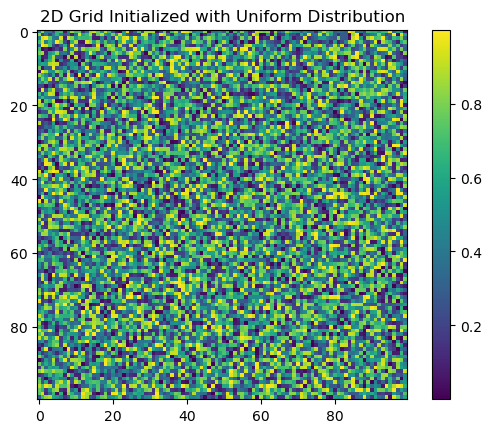

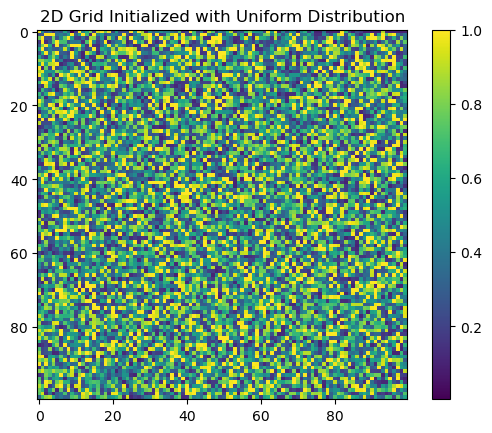

In [31]:
test = SimulationGrid(100)
test.visualize()
plt.show()

test.run_iterations(100000)
# test = grid.current
test.visualize()

### Avalanche size frequency distribution

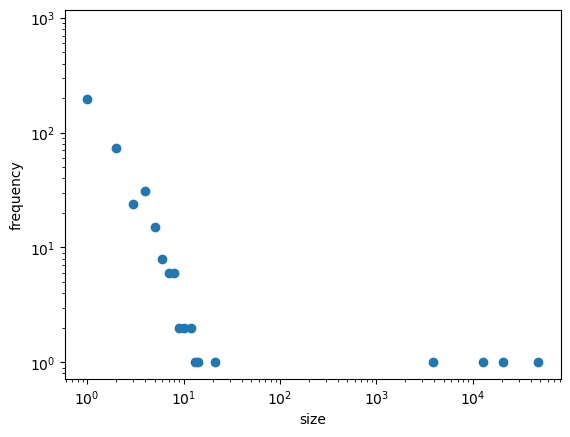

In [32]:
frequencies = test.avalanche_frequencies()
# print(frequencies.shape)
# print(frequencies)
# print()
# print(frequencies[:,0])
plt.scatter(frequencies[:,0],frequencies[:,1])
plt.ylabel('frequency')
plt.xlabel('size')
plt.xscale('log')
plt.yscale('log')
# plt.plot(frequencies[])

### Reading index data